# TODOs:
- refactor clustering plotting to own class
- map RapidMiner's k-mean/dendrogram parameter to scklearn parameter (for Task 2.7)

# Preface

In [1]:
# package imports
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
#from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from collections import Counter

# data imports
dt_customer = pd.read_csv("../data/customer.tsv", delimiter="\t", index_col=0)
dt_students = pd.read_excel("../data/students.xls")
dt_geo = pd.read_excel("../data/geo.xls", index_col=0)

---
# Task 2.1
Use of the k-Means clustering algorithm to generate customer groups based on the number of items each customer has bought and returned. What values of k produce meaningful clusters? Try to  find suitable labels for the created cluster

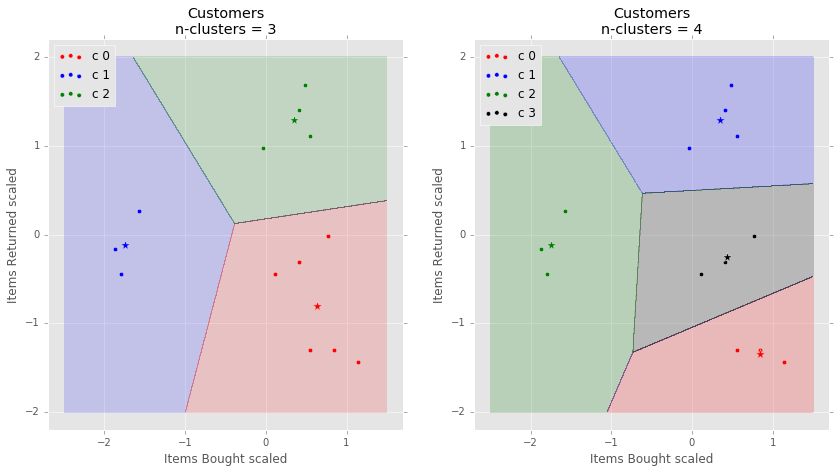

In [2]:
# Slicing the data
dt_customer_bought_returned = dt_customer[["ItemsBought", "ItemsReturned"]]


# Normalizing the values
sc = StandardScaler()
dt_customer_bought_returned_scaled = pd.DataFrame(sc.fit_transform(dt_customer_bought_returned),
                                                  columns=dt_customer_bought_returned.columns,
                                                  index=dt_customer_bought_returned.index)


# Initating & fitting the k-means learners
km_3 = KMeans(n_clusters=3) 
km_3.fit(dt_customer_bought_returned_scaled)
km_4 = KMeans(n_clusters=4) 
km_4.fit(dt_customer_bought_returned_scaled)


# Plotting the clusters with centroid
## setup the plot
colors = ("red", "blue", "green", "black")
cmap = ListedColormap(colors)
fig, axes = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_figheight(7)
axes[0].set_title("Customers\nn-clusters = 3")
axes[1].set_title("Customers\nn-clusters = 4")
for ax in axes:
    ax.set_xlabel("Items Bought scaled")
    ax.set_ylabel("Items Returned scaled")

## left plot with n-clusters = 3
for idx, l in enumerate(np.unique(km_3.labels_)):
    cluster = dt_customer_bought_returned_scaled.ix[km_3.labels_==l,:]
    ### points in cluster
    axes[0].scatter(cluster.iloc[:,0], 
                    cluster.iloc[:,1], 
                    c=colors[idx],
                    label="c {}".format(l))
    ### centroids
    axes[0].scatter(km_3.cluster_centers_[idx][0], 
                    km_3.cluster_centers_[idx][1], 
                    c=colors[idx], 
                    marker="*",
                    s=100)
    ### legend
    axes[0].legend(loc="upper left")
    ### decision region
    x, y = np.linspace(-2.5, 1.5, 1000), np.linspace(-2, 2, 1000)   
    xx, yy = np.meshgrid(x, y)
    z = km_3.predict(np.array([xx.ravel(), yy.ravel()]).T)
    axes[0].contourf(xx, yy, z.reshape(xx.shape), alpha=0.05, cmap=ListedColormap(colors[:3]))
    
## right plot with n-clusters = 4
for idx, l in enumerate(np.unique(km_4.labels_)):
    cluster = dt_customer_bought_returned_scaled.ix[km_4.labels_==l,:]
    ### points in cluster
    axes[1].scatter(cluster.iloc[:,0], 
                    cluster.iloc[:,1], 
                    c=colors[idx],
                    label="c {}".format(l))
    ### centroids
    axes[1].scatter(km_4.cluster_centers_[idx][0], 
                    km_4.cluster_centers_[idx][1], 
                    c=colors[idx], 
                    marker="*",
                    s=100)
    ### legend
    axes[1].legend(loc="upper left")
    ### decision region
    x, y = np.linspace(-2.5, 1.5, 1000), np.linspace(-2, 2, 1000)   
    xx, yy = np.meshgrid(x, y)
    z = km_4.predict(np.array([xx.ravel(), yy.ravel()]).T)
    axes[1].contourf(xx, yy, z.reshape(xx.shape), alpha=0.05, cmap=ListedColormap(colors[:4]))
    

# appending cluster labels to dataframe and add a "return ratio"
dt_customer_labeled = dt_customer\
.assign(km3Label=km_3.labels_)\
.assign(km4Label=km_4.labels_)\
.assign(ReturnRatio=dt_customer["ItemsReturned"]/dt_customer["ItemsBought"])

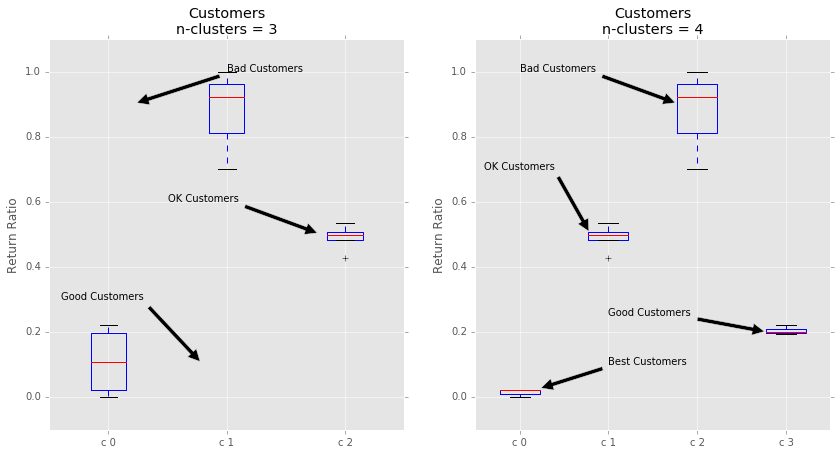

In [3]:
# Evaluate ReturnRatios per Cluster via Boxplot
fig, axes = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_figheight(7)
axes[0].set_title("Customers\nn-clusters = 3")
axes[1].set_title("Customers\nn-clusters = 4")

# left plot
## boxplot
data_k3 = [
    dt_customer_labeled.ix[dt_customer_labeled["km3Label"] == 0, "ReturnRatio"],
    dt_customer_labeled.ix[dt_customer_labeled["km3Label"] == 1, "ReturnRatio"],
    dt_customer_labeled.ix[dt_customer_labeled["km3Label"] == 2, "ReturnRatio"]
]
axes[0].boxplot(data_k3)
axes[0].set_ylim(-.1, 1.1)
axes[0].set_xticklabels(["c 0", "c 1", "c 2"])
axes[0].set_ylabel("Return Ratio")
## annotations
axes[0].annotate("Bad Customers", xy=(1.2,0.9), xytext=(2,1),arrowprops=dict(facecolor='black', shrink=0.05))
axes[0].annotate("OK Customers", xy=(2.8,0.5), xytext=(1.5,0.6),arrowprops=dict(facecolor='black', shrink=0.05))
axes[0].annotate("Good Customers", xy=(1.8,0.1), xytext=(0.6, 0.3),arrowprops=dict(facecolor='black', shrink=0.05))



# right plot
## boxplots
data_k4 = [
    dt_customer_labeled.ix[dt_customer_labeled["km4Label"] == 0, "ReturnRatio"],
    dt_customer_labeled.ix[dt_customer_labeled["km4Label"] == 1, "ReturnRatio"],
    dt_customer_labeled.ix[dt_customer_labeled["km4Label"] == 2, "ReturnRatio"],
    dt_customer_labeled.ix[dt_customer_labeled["km4Label"] == 3, "ReturnRatio"]
]
axes[1].boxplot(data_k4)
axes[1].set_ylim(-.1, 1.1)
axes[1].set_xticklabels(["c 0", "c 1", "c 2", "c 3"])
axes[1].set_ylabel("Return Ratio")
## annotations
axes[1].annotate("Bad Customers", xy=(2.8, 0.9), xytext=(1,1),arrowprops=dict(facecolor='black', shrink=0.05))
axes[1].annotate("OK Customers", xy=(1.8, 0.5), xytext=(0.6, 0.7),arrowprops=dict(facecolor='black', shrink=0.05))
axes[1].annotate("Good Customers", xy=(3.8, 0.2), xytext=(2,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
axes[1].annotate("Best Customers", xy=(1.2, 0.025), xytext=(2,0.1),arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

---
# Task 2.2
Identify the products that are bought and returned by our likely bad customers.

In [4]:
dt_customer_labeled.loc[
    dt_customer_labeled["km3Label"] == 0,
    "Product"].unique()

array([1365, 1343, 1236, 1764, 1547, 1265])

The product `2435` is the only product bought & returned by the bad customer segment.

---
# Task 2.3
Find the most common ZipCodes of our best customers.

In [5]:
Counter(dt_customer_labeled.loc[
    dt_customer_labeled["km3Label"] == 1,
    "ZipCode"
].values)

Counter({3: 1, 4: 1, 8: 1})

The ZipCodes `1` as well as `2` occur with the same frequency.

---
# Task 2.4
Exchange the k-Means operator by the Agglomerative Clustering operator and inspect the resulting dendogram. What does this  gure tell you about your customer groups?

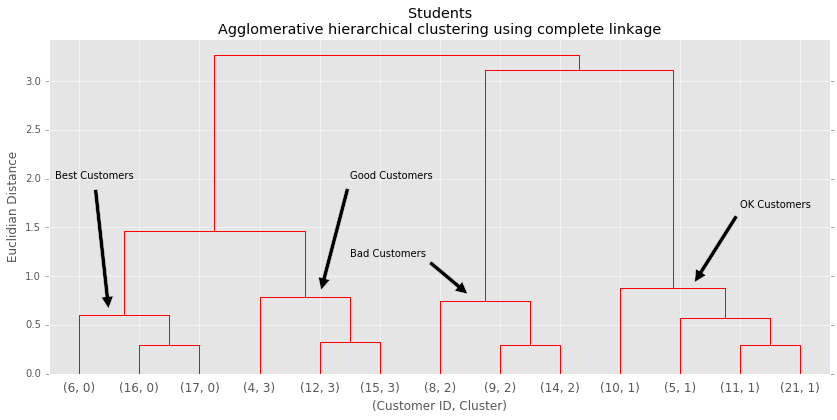

In [6]:
# Compute clusters by using complete linkage
row_clusters = linkage(dt_customer_bought_returned_scaled, method="complete")

# Draw dendogram
## cosmetics
labels = list(zip(dt_customer_labeled.index.values, dt_customer_labeled["km4Label"].values))
plt.rcParams["figure.figsize"] = [14, 6]
plt.ylabel("Euclidian Distance")
plt.xlabel("(Customer ID, Cluster)")
plt.title("Students\nAgglomerative hierarchical clustering using complete linkage")
## basic dendrogram
set_link_color_palette(["red"])
row_dendr = dendrogram(row_clusters, labels=labels, color_threshold=np.inf)
## annotations
plt.annotate("Best Customers", xy=(10,.6), xytext=(1,2), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Good Customers", xy=(45,.8), xytext=(50,2), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Bad Customers", xy=(70,.8), xytext=(50,1.2), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("OK Customers", xy=(107,.9), xytext=(115,1.7), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

---
# Task 2.5
Create four clusters from the hierarchical clustering and think about possible labels for the created clusters. Please use MixedMeasures with MixedEuclideanDistance as proximity measure.

See Task 2.4

---
# Task 2.6
Make use of the k-Means clustering algorithm to group the students based on their mark and the number of attended courses. Does one attribute dominate the result of the clustering? What can you do about this? Assign suitable labels to your clusters.

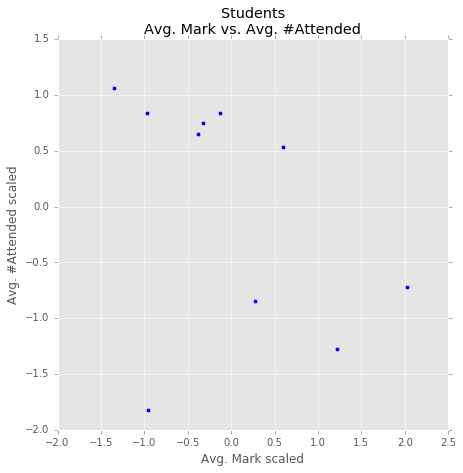

In [7]:
# Slice and aggregate the dataset
dt_students_by_name_mark_attended = dt_students.groupby("Name")[["Mark", "Attended"]].agg(np.mean)


# Normalize the values
sc.fit(dt_students_by_name_mark_attended)
dt_students_by_name_mark_attended_scaled = pd.DataFrame(sc.transform(dt_students_by_name_mark_attended),
                                                index=dt_students_by_name_mark_attended.index,
                                                columns=dt_students_by_name_mark_attended.columns)


# Plot to get a first intuition
plt.rcParams["figure.figsize"] = [7,7]
plt.scatter(dt_students_by_name_mark_attended_scaled["Mark"], dt_students_by_name_mark_attended_scaled["Attended"])
plt.xlabel("Avg. Mark scaled")
plt.ylabel("Avg. #Attended scaled")
plt.title("Students\nAvg. Mark vs. Avg. #Attended")
plt.show()

Based on the scatter plot a number of `n=3 clusters` is used for the k-means clustering.

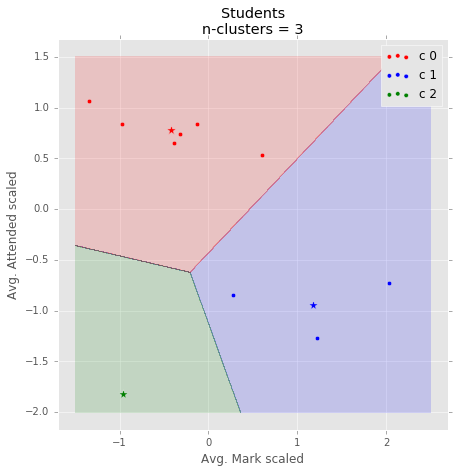

In [8]:
# initiate and train the k-means lerner
km_3 = KMeans(n_clusters=3)
km_3.fit(dt_students_by_name_mark_attended_scaled)


# Plotting the clusters with centroid
## setup the plot
colors = ("red", "blue", "green")
cmap = ListedColormap(colors)
plt.rcParams["figure.figsize"] = [7,7]
plt.title("Students\nn-clusters = 3")
plt.xlabel("Avg. Mark scaled")
plt.ylabel("Avg. Attended scaled")
for idx, l in enumerate(np.unique(km_3.labels_)):
    cluster = dt_students_by_name_mark_attended_scaled.ix[km_3.labels_==l,:]
    ### points in cluster
    plt.scatter(cluster.iloc[:,0], 
                    cluster.iloc[:,1], 
                    c=colors[idx],
                    label="c {}".format(l))
    ### centroids
    plt.scatter(km_3.cluster_centers_[idx][0], 
                    km_3.cluster_centers_[idx][1], 
                    c=colors[idx], 
                    marker="*",
                    s=100)
    ### legend
    plt.legend(loc="upper right")
    ### decision region
    x, y = np.linspace(-1.5, 2.5, 1000), np.linspace(-2, 1.5, 1000)   
    xx, yy = np.meshgrid(x, y)
    z = km_3.predict(np.array([xx.ravel(), yy.ravel()]).T)
    plt.contourf(xx, yy, z.reshape(xx.shape), alpha=0.05, cmap=ListedColormap(colors[:3]))

---
# Task 2.7
Experiment with different parameter settings for calculating the cluster similarity. The resulting dendogram should help you to interpret your results by inspecting the distance between two clusters before they get joined.

In [78]:
# ...

---
# Task 2.8
Cluster the data using the k-Means operator. Do the calculated clusters represent the original three areas?

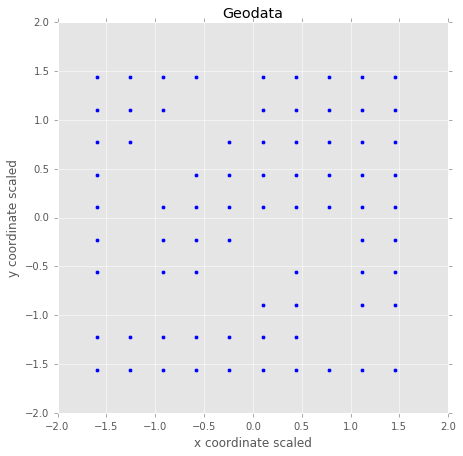

In [10]:
# Normalize geo data
sc = StandardScaler()
dt_geo_x_y = dt_geo.loc[:, ["x", "y"]]
dt_geo_x_y_scaled = pd.DataFrame(sc.fit_transform(dt_geo_x_y),
                             columns=dt_geo_x_y.columns,
                             index=dt_geo_x_y.index)


# Initial scatterplot to see the different areas
plt.rcParams["figure.figsize"] = [7,7]
plt.scatter(dt_geo_x_y_scaled["x"], dt_geo_x_y_scaled["y"])
plt.title("Geodata")
plt.xlabel("x coordinate scaled")
plt.ylabel("y coordinate scaled")
plt.show()

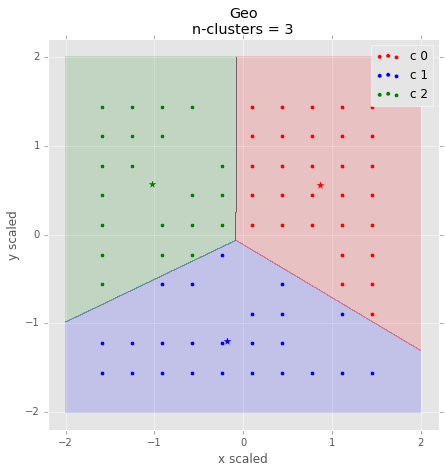

In [11]:
# cluster the data with k-means, 3 clusters
km_3 = KMeans(n_clusters=3)
km_3.fit(dt_geo_x_y_scaled)


# Plotting the clusters with centroid
## setup the plot
colors = ("red", "blue", "green")
cmap = ListedColormap(colors)
plt.rcParams["figure.figsize"] = [7,7]
plt.title("Geo\nn-clusters = 3")
plt.xlabel("x scaled")
plt.ylabel("y scaled")
for idx, l in enumerate(np.unique(km_3.labels_)):
    cluster = dt_geo_x_y_scaled.ix[km_3.labels_==l,:]
    ### points in cluster
    plt.scatter(cluster.iloc[:,0], 
                    cluster.iloc[:,1], 
                    c=colors[idx],
                    label="c {}".format(l))
    ### centroids
    plt.scatter(km_3.cluster_centers_[idx][0], 
                    km_3.cluster_centers_[idx][1], 
                    c=colors[idx], 
                    marker="*",
                    s=100)
    ### legend
    plt.legend(loc="upper right")
    ### decision region
    x, y = np.linspace(-2, 2, 1000), np.linspace(-2, 2, 1000)   
    xx, yy = np.meshgrid(x, y)
    z = km_3.predict(np.array([xx.ravel(), yy.ravel()]).T)
    plt.contourf(xx, yy, z.reshape(xx.shape), alpha=0.05, cmap=ListedColormap(colors[:3])) 

As expected k-means is not able to recreate the original three clusters. For a denisity based approach see task 2.9.

# Task 2.9
Think about which values for epsilon make sense for this dataset. Apply them (set min points to 3) and try to reproduce the original clusters of the dataset.

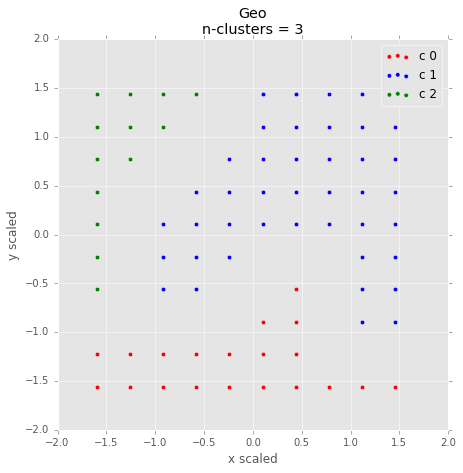

In [77]:
# Learn and fit the DBSCAN
db = DBSCAN(eps=.5,min_samples=3)
tmp = db.fit_predict(dt_geo_x_y_scaled)

# Plotting the clusters with centroid
## setup the plot
colors = ("red", "blue", "green", "black")
cmap = ListedColormap(colors)
plt.rcParams["figure.figsize"] = [7,7]
plt.title("Geo\nn-clusters = 3")
plt.xlabel("x scaled")
plt.ylabel("y scaled")
for idx, l in enumerate(np.unique(db.labels_)):
    cluster = dt_geo_x_y_scaled.ix[db.labels_==l,:]
    ### points in cluster
    plt.scatter(cluster.iloc[:,0], 
                    cluster.iloc[:,1], 
                    c=colors[idx],
                    label="c {}".format(l))
    ### legend
    plt.legend(loc="upper right")